# Introdução

Análise da série temporal da média de riscos de fogos diariamente no Brasil no ano de 2024. O cálculo do Risco de Fogo leva em conta os seguintes fatores:
- Quantidade de dias seguidos sem chuva.
- Os efeitos do tipo e do ciclo natural de desfolhamento da vegetação.
- Temperatura máxima e umidade relativa mínima do ar diárias.
- Presença de fogo no local de interesse.

No processo de modelagem foram utilizados os modelos SARIMA, SARIMAX e Redes Neurais Long short-term memory (LSTM).
Os dados foram disponibilizados pelo Instituto Nacional de Pesquisas Espaciais (INPE) e podem ser acessados na seguinte fonte: https://www.kaggle.com/datasets/mayaravalliero/fire-watch-brazil-2024.

# Importação das bibliotecas 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

# Carregamento e transformação dos dados

In [44]:
df1 = pd.read_csv("/kaggle/input/fire-watch-brazil-2024/Dataset_FireWatch_Brazil_Q1_2024.csv")
df2 = pd.read_csv("/kaggle/input/fire-watch-brazil-2024/Dataset_FireWatch_Brazil_Q2_2024.csv")
df3 = pd.read_csv("/kaggle/input/fire-watch-brazil-2024/Dataset_FireWatch_Brazil_Q3_2024.csv")
df4 = pd.read_csv("/kaggle/input/fire-watch-brazil-2024/Dataset_FireWatch_Brazil_Q4_2024.csv")
df = pd.concat([df1, df2, df3, df4])
df

,data,municipio,estado,bioma,avg_numero_dias_sem_chuva,avg_precipitacao,avg_risco_fogo,avg_frp
0,2024-01-01,VALE DO ANARI,RONDÔNIA,Amazônia,0.0,1698.00,0.00,13.00
1,2024-01-01,SÃO GABRIEL DA CACHOEIRA,AMAZONAS,Amazônia,0.2,206.80,0.00,81.40
2,2024-01-01,MANAQUIRI,AMAZONAS,Amazônia,0.0,60.00,0.00,27.00
3,2024-01-01,JUTAÍ,AMAZONAS,Amazônia,2.0,776.00,0.00,211.00
4,2024-01-01,AUTAZES,AMAZONAS,Amazônia,0.0,2.22,0.00,97.67
...,...,...,...,...,...,...,...,...
103231,2024-12-31,NOVA MAMORÉ,RONDÔNIA,Amazônia,2.0,653.50,5.50,45751.50
103232,2024-12-31,ITAQUI,RIO GRANDE DO SUL,Pampa,11.0,0.00,1.00,45753.00
103233,2024-12-31,EPITACIOLÂNDIA,ACRE,Amazônia,2.0,187.50,6.00,45738.50
103234,2024-12-31,LÁBREA,AMAZONAS,Amazônia,0.0,603.00,1.00,45813.00


In [45]:
df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d', errors='coerce')

In [46]:
df

,data,municipio,estado,bioma,avg_numero_dias_sem_chuva,avg_precipitacao,avg_risco_fogo,avg_frp
0,2024-01-01,VALE DO ANARI,RONDÔNIA,Amazônia,0.0,1698.00,0.00,13.00
1,2024-01-01,SÃO GABRIEL DA CACHOEIRA,AMAZONAS,Amazônia,0.2,206.80,0.00,81.40
2,2024-01-01,MANAQUIRI,AMAZONAS,Amazônia,0.0,60.00,0.00,27.00
3,2024-01-01,JUTAÍ,AMAZONAS,Amazônia,2.0,776.00,0.00,211.00
4,2024-01-01,AUTAZES,AMAZONAS,Amazônia,0.0,2.22,0.00,97.67
...,...,...,...,...,...,...,...,...
103231,2024-12-31,NOVA MAMORÉ,RONDÔNIA,Amazônia,2.0,653.50,5.50,45751.50
103232,2024-12-31,ITAQUI,RIO GRANDE DO SUL,Pampa,11.0,0.00,1.00,45753.00
103233,2024-12-31,EPITACIOLÂNDIA,ACRE,Amazônia,2.0,187.50,6.00,45738.50
103234,2024-12-31,LÁBREA,AMAZONAS,Amazônia,0.0,603.00,1.00,45813.00


In [47]:
#Agrupando a média diaria em todo Brasil.
df_grouped = df.groupby('data').agg({
    'avg_risco_fogo': 'mean',
    'avg_numero_dias_sem_chuva': 'mean',
    'avg_precipitacao': 'mean', 
    'avg_frp': 'mean'
}).reset_index()
df_grouped

,data,avg_risco_fogo,avg_numero_dias_sem_chuva,avg_precipitacao,avg_frp
0,2024-01-01,37.413603,2.879190,401.888016,208.738219
1,2024-01-02,38.330516,3.083238,383.892092,137.255731
2,2024-01-03,31.139870,2.414703,190.503792,152.001840
3,2024-01-04,32.421012,2.473824,250.075104,135.539539
4,2024-01-05,31.522730,2.578324,151.545716,141.940135
...,...,...,...,...,...
341,2024-12-27,-1.195937,9.341069,39.935766,36650.810051
342,2024-12-28,-12.344586,7.371260,121.547536,37708.577860
343,2024-12-29,-38.713667,8.136083,191.399417,37007.581533
344,2024-12-30,-8.536431,8.700821,138.000718,38335.252073


In [48]:
# Retirando os valores de 'avg_risco_fogo' que são maiores que 0
#Não foi possível indentificar o motivo dos valores negativos em nenhuma fonte do INPE
df_cleaned = df_grouped[df_grouped['avg_risco_fogo'] > 0]
df_cleaned

,data,avg_risco_fogo,avg_numero_dias_sem_chuva,avg_precipitacao,avg_frp
0,2024-01-01,37.413603,2.879190,401.888016,208.738219
1,2024-01-02,38.330516,3.083238,383.892092,137.255731
2,2024-01-03,31.139870,2.414703,190.503792,152.001840
3,2024-01-04,32.421012,2.473824,250.075104,135.539539
4,2024-01-05,31.522730,2.578324,151.545716,141.940135
...,...,...,...,...,...
331,2024-12-17,0.850803,5.398282,117.827308,35644.471930
334,2024-12-20,2.182837,5.486876,158.425834,35637.754024
335,2024-12-21,6.172437,5.517708,92.539831,36845.840193
336,2024-12-22,13.479711,6.412803,55.742500,36208.738338


In [49]:
df_cleaned = df_cleaned.set_index("data")

In [50]:
df_cleaned.sort_values(by="avg_risco_fogo", ascending=False)

,avg_risco_fogo,avg_numero_dias_sem_chuva,avg_precipitacao,avg_frp
data,,,,
2024-09-27,652.424752,46.512358,3925.248339,78.651646
2024-09-09,90.832204,52.051711,5.377609,141.733235
2024-09-05,90.460323,54.277748,32.767598,137.705820
2024-09-08,90.240889,52.827491,2.099172,145.486179
2024-09-06,89.650671,54.874093,12.641582,142.937276
...,...,...,...,...
2024-12-20,2.182837,5.486876,158.425834,35637.754024
2024-12-26,1.578710,8.670025,36.052617,38299.102679
2024-12-08,1.446191,4.027223,192.313458,35037.649845


In [51]:
df_cleaned = df_cleaned.drop(["2024-09-27"])
df_cleaned.sort_values(by="avg_risco_fogo", ascending=False)

,avg_risco_fogo,avg_numero_dias_sem_chuva,avg_precipitacao,avg_frp
data,,,,
2024-09-09,90.832204,52.051711,5.377609,141.733235
2024-09-05,90.460323,54.277748,32.767598,137.705820
2024-09-08,90.240889,52.827491,2.099172,145.486179
2024-09-06,89.650671,54.874093,12.641582,142.937276
2024-09-04,89.272952,50.142337,21.234584,176.511510
...,...,...,...,...
2024-12-20,2.182837,5.486876,158.425834,35637.754024
2024-12-26,1.578710,8.670025,36.052617,38299.102679
2024-12-08,1.446191,4.027223,192.313458,35037.649845


# Análise temporal da série temporal de riscos de fogos

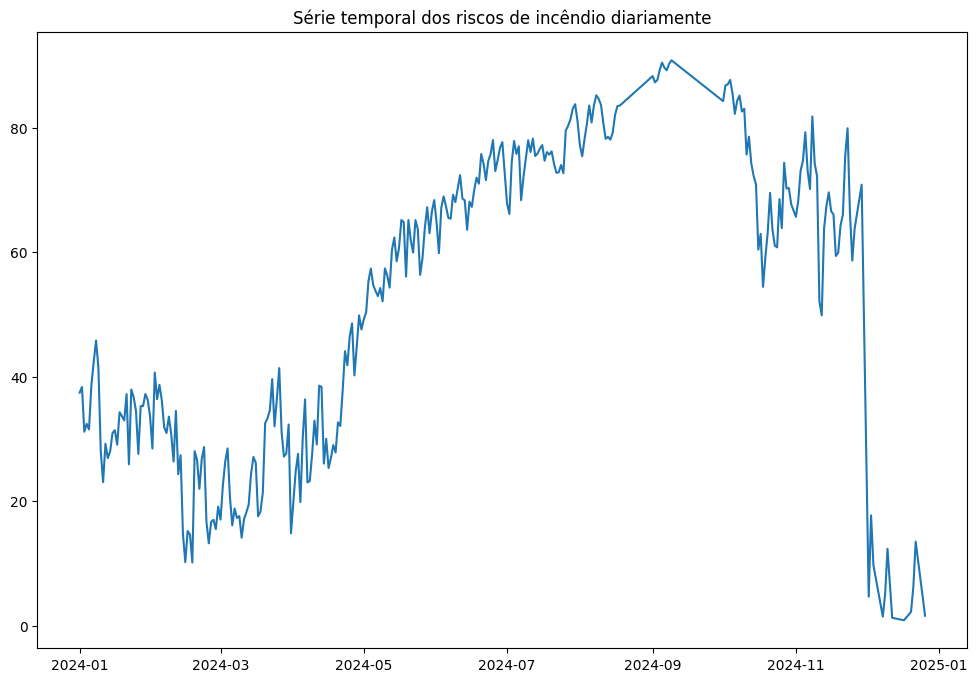

In [52]:
plt.figure(figsize=(12, 8))
plt.title("Série temporal dos riscos de incêndio diariamente")
plt.plot(df_cleaned['avg_risco_fogo'])

Para a decomposição da série será utilizado o método de decomposição sazonal. Esse método divide a série temporal nos componentes de tendência, sazonalidade e de resíduos. A tendência mede o crescimento da série durante o tempo, a sazonalidade é a divisão da série em periodos baseado em algum padrão e os resíduos representam externalidades e eventos aleatórios que afetam os dados da série. Como as amplitudes da série temporal considerando a sazonalidade dividida em períodos de tempo diária não é constante o modelo multiplicativo será mais apropriado.

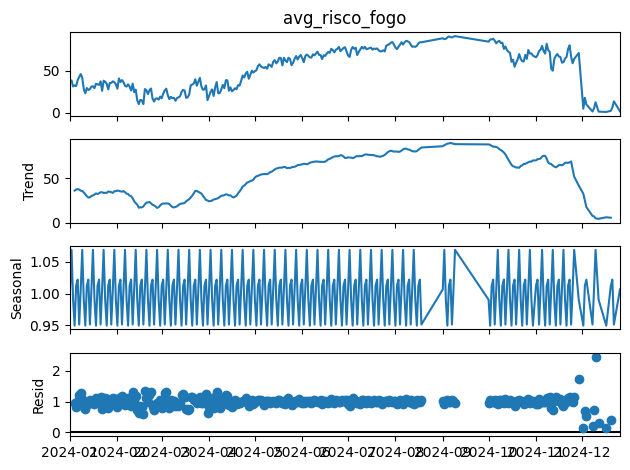

In [53]:
decomposition = seasonal_decompose(df_cleaned['avg_risco_fogo'], model='multiplicative', period=7)
decomposition.plot()
plt.show()

De Janeiro até metade de março as médias de risco de fogos parecem ter tido uma diminuição na tendência. No fim de Março ocorreu um crescimento repetino, acompanhado logo depois com uma queda no inicio de Abril. A partir de Abril houve uma tendência não linear de crescimento que termina proximo do linear no inicio de Outubro. Foi dentro desse período que foram registrados os maiores picos chegando a máximas de mais de 90%. Do inicio até metade de Outubro houve uma queda que precedeu o crescimento até o fim de Novembro. A partir dai a tendência só diminuiu até o fim da série chegando aos menores registros. Os resíduos de Janeiro até o final de Abril e do final de Novembro até o fim de Dezembro da série tiveram uma variação maior, o que indica que possívelmente existiu alguma externalidiade ou evento aleatório significativo nesses períodos. Ademais, a decomposição identificou a sazonalidade menos nos meses de Setembro e Dezembro o que se relaciona com a tendência constante e a queda abrupta nos respectivos meses.

Outra propriedade importante das séries temporais é a estacionariedade que ocorre quando as propriedades (média, variância, etc.) da série são constantes ao longo do tempo. Através da análise anterior foi observado que existem tendências de alta e baixa não constantes em diferentes períodos de tempo o que indica que a série não é estacionaria. Para confirma se a série é estacionária ou não pode-se utilizar testes estatísticos como os de Dickey Fuller e KPSS.

Para o de Fuller temos o seguinte resultado:

In [54]:
result = adfuller(df_cleaned['avg_risco_fogo'])

print(f'Estatística ADF: {result[0]}')
print(f'P-valor: {result[1]}')

if result[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série NÃO é estacionária.")

Estatística ADF: -1.0762544323564613
P-valor: 0.7244478845688017
A série NÃO é estacionária.


Já para o teste KPSS temos:

In [55]:
result = kpss(df_cleaned['avg_risco_fogo'], regression='c')
print(f"Estatística do teste: {result[0]}")
print(f"Valor-p: {result[1]}")
print(f"Lags usados: {result[2]}")
print(f"Valores críticos: {result[3]}")

if result[1] < 0.05:
    print("A série NÃO é estacionária.")
else:
    print("A série é estacionária.")

Estatística do teste: 1.5600500617188933
Valor-p: 0.01
Lags usados: 10
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
A série NÃO é estacionária.


<ipython-input-55-b75e02a80bcf>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_cleaned['avg_risco_fogo'], regression='c')


## Diferenciação

A diferenciação é uma técnica útilizada para remover os sinais de tendência e diminuir a variância, desta forma é possível transforma a série em estacionária. A nova série temporal será o resultado da diferença entre o valor do período de tempo t com o valor anterior t-1.

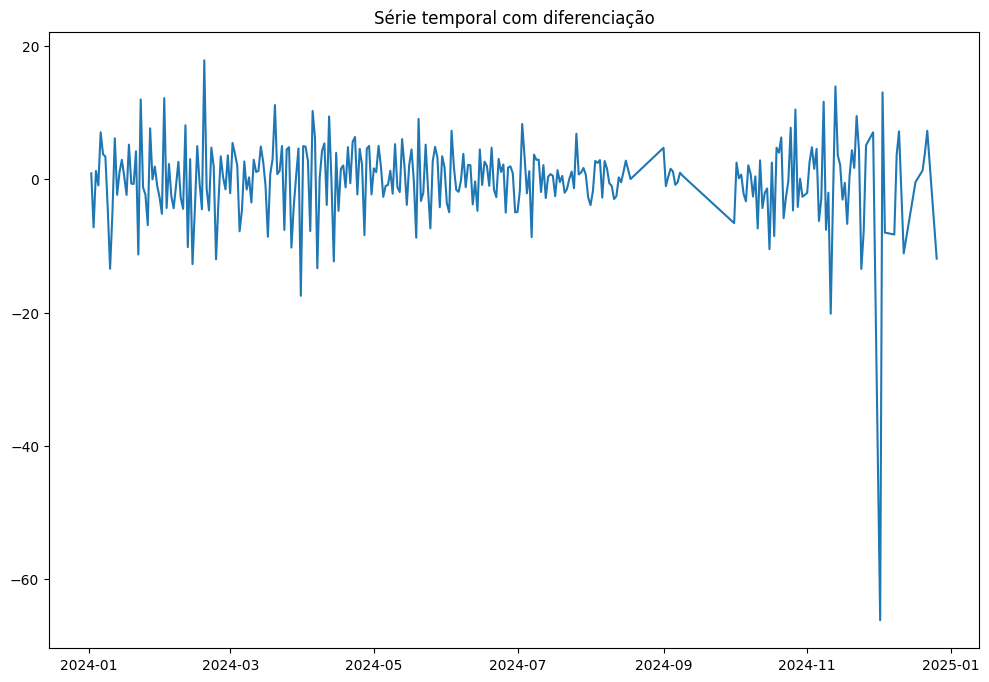

In [56]:
serie_diff = df_cleaned['avg_risco_fogo'].diff().dropna()
plt.figure(figsize=(12, 8))
plt.title("Série temporal com diferenciação")
plt.plot(serie_diff)

In [57]:
result = adfuller(serie_diff)

print(f'Estatística ADF: {result[0]}')
print(f'P-valor: {result[1]}')

if result[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série NÃO é estacionária.")

Estatística ADF: -15.823754332968837
P-valor: 1.0129976897778138e-28
A série é estacionária.


In [58]:
result = kpss(serie_diff, regression='c')
print(f"Estatística do teste: {result[0]}")
print(f"Valor-p: {result[1]}")
print(f"Lags usados: {result[2]}")
print(f"Valores críticos: {result[3]}")

if result[1] < 0.05:
    print("A série NÃO é estacionária.")
else:
    print("A série é estacionária.")

Estatística do teste: 0.30934359784601034
Valor-p: 0.1
Lags usados: 7
Valores críticos: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
A série é estacionária.


<ipython-input-58-d3e583f31a8e>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(serie_diff, regression='c')


Os modelos de autoregressão já fazem a diferenciação interna automaticamente por meio dos parâmetros d e D, desta forma a série diferenciada não será necessária nos processos de modelagem.

## Lags correlacionados

Para a previsão utilizando uma única váriavel é necessário que o período atual da série seja explicado pelos períodos anteriores (lags). Abaixo estão os  gráficos de autocorrelação e autocorrelação parcial (autocorrelação de um lag tirando a influência de lags anteriores) na série diferenciada.

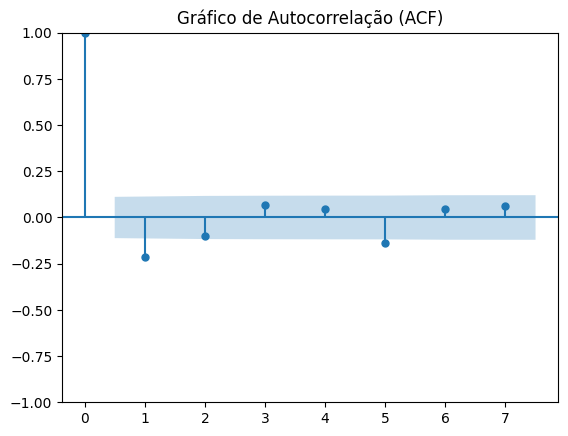

In [59]:
plot_acf(serie_diff, lags=7, alpha=0.05)  # alpha=0.05 para intervalo de confiança 95%
plt.title("Gráfico de Autocorrelação (ACF)")
plt.show()

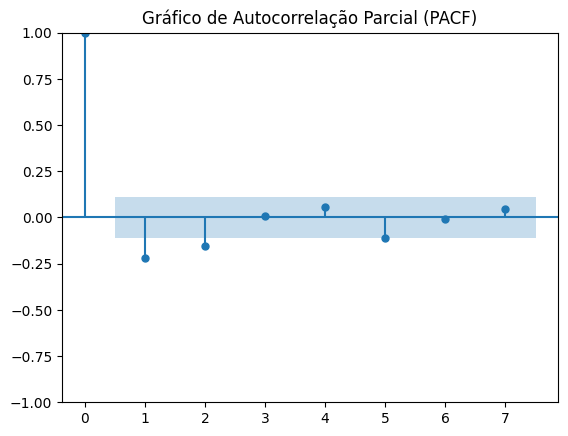

In [60]:
plot_pacf(serie_diff, lags=7, alpha=0.05, method='ols')  # method='ols' para estimação
plt.title("Gráfico de Autocorrelação Parcial (PACF)")
plt.show()

Apenas o primeiro lag apresentou autocorrelação significativa. Isso significa que provavelmente o modelo de autoregressão SARIMA não apresentara bons resultados, já que não é possível explicar as previsões futuras com os resultados atuais utilizando apenas um váriavel.

## Modelos para a previsão da série temporal

### ARIMA

O ARIMA é a combinação dos métodos de diferenciação e os modelos de autoregressão e média móvel que pode ser descrito matematicamente como $$\acute{y_t} = c + \phi_1\acute{y}_{t-1} + ... + \phi_p\acute{y}_{t-p} + \theta_1 + \theta_1e_{t-1} + ... + \theta_qe_{t-q} + e_t$$
Onde $\acute{y}_t$ é a série diferenciada. A equação acima é o que descreve o modelo ARIMA$(p, d, q)$, onde:

- $p$ é a ordem do modelo autoregressivo;
- $d$ é o grau de diferenciação;
- $q$ é a ordem do modelo de média móvel.

O SARIMA séria o ARIMA$(p, d, q)(P, D, Q)_m$. Onde o primeiro parênteses se refere à parte não-sazonal do modelo e o segundo à parte sazonal. $m$ corresponde ao número de períodos sazonais. A partir desses parâmetros séria possível ajustar um modelo de previsão.

In [61]:
tamanho_treino = int(len(df_cleaned['avg_risco_fogo']) * 0.8)  # 80% para treino e 20% para teste
serie_treino = df_cleaned['avg_risco_fogo'][:tamanho_treino]
serie_teste = df_cleaned['avg_risco_fogo'][tamanho_treino:]

Para determinar os parâmetros do modelo é preciso aplicar a metodologia Box-Jenkins que é um conjunto de etapas (Identificação, Estimação e Diagnóstico dos resíduos) para escolher esses parâmetros. O AutoARIMA consegue automatizar esse processo através do Grid Search.

In [62]:
modelo_sarima = auto_arima(serie_treino, seasonal=True, m=7, trace=True)
print(modelo_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1435.488, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1461.235, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1450.638, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1444.768, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1459.644, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=1440.201, Time=0.39 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=1439.857, Time=0.38 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=1436.965, Time=0.91 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=1436.796, Time=1.03 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=1439.879, Time=0.20 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=1440.941, Time=0.60 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=1439.671, Time=0.57 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=1438.600, Time=1.34 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=1433.556, Time=0.81 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept

Uma das etapas para verificar a eficácia do modelo é a análise de residuos que pode ser feita utilizando uma função do próprio modelo:

[]

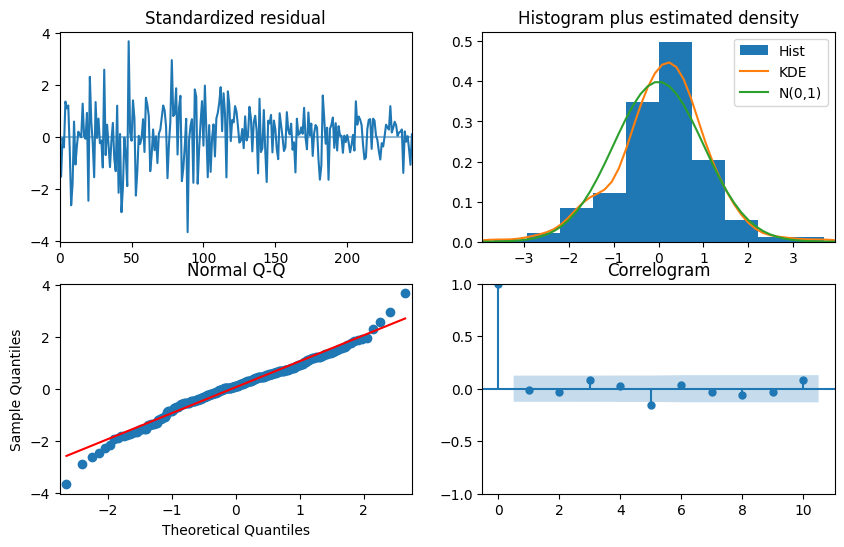

In [63]:
modelo_sarima.plot_diagnostics(figsize=(10,6))
plt.plot()

Nos gráficos de diagnóstico foi possível identificar que não existe um padrão nos residuos e que o correlograma não apresentou resultados estatisticamente significativos, o que é um sinal positivo para a avaliação do modelo. Todavia a maior parte dos valores estão distantes da linha vermelha no terceiro gráfico, o que indica a falta de normalidade. Ademais, tanto o histograma que não segue a distribuição normal no QQ-Plot quanto o teste Jarque-Bera (JB) com p < 0,05 também são indicativos do mesmo problema. Considerando esses fatores o modelo não passou no teste de resíduos.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


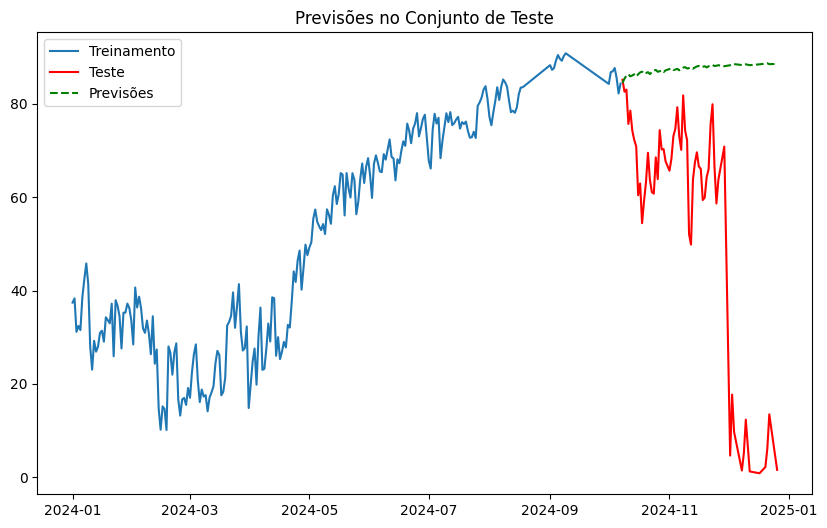

In [64]:
previsao = modelo_sarima.predict(n_periods=len(serie_teste))

plt.figure(figsize=(10, 6))
plt.plot(serie_treino, label='Treinamento')
plt.plot(serie_teste, label='Teste', color='red')
plt.plot(serie_teste.index, previsao, label='Previsões', color='green', linestyle='--')
plt.legend()
plt.title('Previsões no Conjunto de Teste')
plt.show()

Graficamente o modelo não conseguiu se ajustar a série temporal. 

Outra forma de avaliar o desempenho de um modelo é utilizando as métricas de avaliação. Para modelos de regressão as métrica mais comuns são o R-quadrado, Erro Médio Absoluto (MAE) e o Erro Quadrático Médio (MSE). O MAE mede a média de diferenças absolutas entre os valores reais e os de previsão, já o MSE é média dos quadrados das diferenças entre as previsões do modelo e os valores reais e por fim o R-quadrado que quantifica a proporção da variância na variável de destino que é explicada pelo modelo. O MSE e o MAE representam a média de erros em unidades da váriavel de destino e o R-quadrado é um valor entre 0 e 1 em que valores proximos de 1 indicam que o modelo explica uma grande parte da variabilidade nos dados, enquanto valores próximos a 0 indicam que o modelo não consegue explicar essa váriabilidade.

In [65]:
r2 = r2_score(serie_teste, previsao)
rmse = np.sqrt(mean_squared_error(serie_teste, previsao))
mae = mean_absolute_error(serie_teste, previsao)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R²: -1.5005
RMSE: 40.5574
MAE: 30.9773


Considerando que os valores da serie de teste estão entre aproximadamente entre 93 e 0 é possível determinar os valores de RMSE e MAE estão muito altos o que é um péssimo indicador para a avaliação do modelo. O R-quadrado negativo representa o mesmo problema.

### SARIMAX

Para adicionar váriaveis externas que possam ajudar na modelagem dos dados é possível utilizar SARIMAX. Esse modelo faz a combinação do SARIMA com váriaveis exógenas (externas) que possam ter algum tipo de correlação com a váriavel target. De acordo com o INPE, os dias de chuva são levados em conta no cálculo de risco de fogo o que justifica uma possível correlação forte entre as duas váriaveis. Já para precipitação e FRP, o projeto disponível em https://www.kaggle.com/code/gabkgonzales/an-lise-dos-inc-ndios-no-brasil-em-2024 identificou uma baixa correlação, entretanto nem sempre a correlação entre as váriaveis vai ter a mesma proporcionalidade ao impacto no modelo, por isso foram feitos testes para avaliar o desempenho do modelo com diferentes combinações de váriaveis. A combinação a seguir foi a que melhor apresentou resultados.

In [66]:
serie_treino = df_cleaned.iloc[:tamanho_treino]
serie_teste = df_cleaned.iloc[tamanho_treino:]

y_treino = serie_treino['avg_risco_fogo']
y_teste = serie_teste['avg_risco_fogo']

exogenas_treino = serie_treino[['avg_numero_dias_sem_chuva', 'avg_precipitacao']]
exogenas_teste = serie_teste[['avg_numero_dias_sem_chuva', 'avg_precipitacao']]

In [67]:
modelo_sarimax = SARIMAX(y_treino,  
                    order = (1,1,1),
                    seasonal_order = (1,0,1,7),
                    exog = exogenas_treino
                   ).fit()
modelo_sarimax.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                    avg_risco_fogo   No. Observations:                  247
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -675.176
Date:                           Sat, 29 Mar 2025   AIC                           1364.352
Time:                                   19:10:35   BIC                           1388.889
Sample:                                        0   HQIC                          1374.232
                                           - 247                                         
Covariance Type:                             opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
avg_numero_dias_sem_chuva     0.7014      0.082      8.574      0.000       0.541       0.862
avg_precipitacao             -0.0136      0.002     -6.872      0.000      -0.017      -0.010
ar.L1                         0.6360      0.080      7.935      0.000       0.479       0.793
ma.L1                        -0.9127      0.044    -20.662      0.000      -0.999      -0.826
ar.S.L7                       0.7551      0.127      5.961      0.000       0.507       1.003
ma.S.L7                      -0.5970      0.159     -3.763      0.000      -0.908      -0.286
sigma2                       14.3251      1.068     13.412      0.000      12.232      16.419
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                18.40
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
previsao = modelo_sarimax.forecast(len(y_teste), exog = exogenas_teste)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


[]

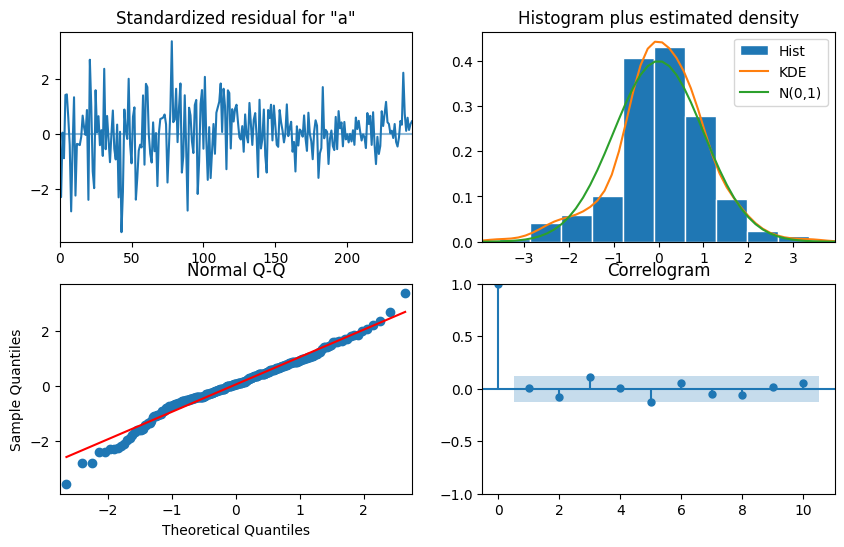

In [69]:
modelo_sarimax.plot_diagnostics(figsize=(10, 6))
plt.plot()

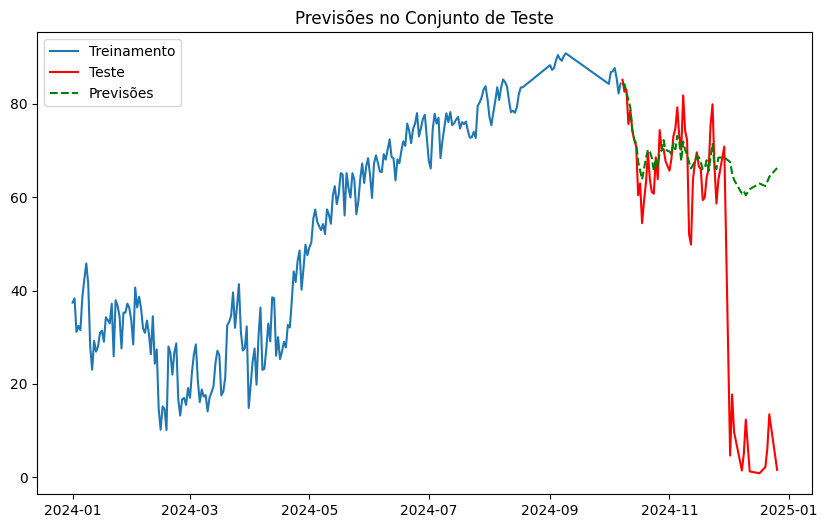

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(y_treino, label='Treinamento')
plt.plot(y_teste, label='Teste', color='red')
plt.plot(y_teste.index, previsao, label='Previsões', color='green', linestyle='--')
plt.legend()
plt.title('Previsões no Conjunto de Teste')
plt.show()

In [71]:
r2 = r2_score(y_teste, previsao)
rmse = np.sqrt(mean_squared_error(y_teste, previsao))
mae = mean_absolute_error(y_teste, previsao)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.0017
RMSE: 25.6263
MAE: 14.1972


O SARIMAX apresentou melhores resultados, porém ainda teve problemas de ajuste em relação aos valores reais e os valores das métricas não são satisfatorias.

### Redes neurais LSTM

O SARIMAX não conseguiu criar um modelo de regressão satisfatório, porém existem outras alternativas para as séries temporais. O Long Short-Term Memory (LSTM) é uma arquitetura de rede neural recorrente (RNN) que foi criada para resolver problemas associados com dependências de longo prazo em dados sequências.  Introduzidas por Hochreiter e Schmidhuber em 1997, as LSTM são eficazes em tarefas que exigem a memorização de informações por longos períodos, como tradução automática, previsão de séries temporais e reconhecimento de fala. 

Uma unidade LSTM possui três portas principais: entrada, esquecimento e saída, além de um vetor de estado da célula que armazena informações ao longo do tempo.

- Porta de Entrada: Controla quais informações novas são armazenadas no estado da célula, usando uma função sigmoide.
- Porta de Esquecimento: Decide quais informações do estado anterior devem ser descartadas, também com uma função sigmoide.
- Porta de Saída: Determina quais partes do estado da célula serão usadas para calcular o estado oculto atual.
- Vetor de Estado da Célula: Mantém informações ao longo do tempo, atualizado com base nas portas de entrada e esquecimento.

O LSTM consegue capturar relações mais complexas e pode ter um desempenho melhor para encontrar o modelo de regressão em comparação ao SARIMAX. 

Dois aspectos importantes para a preparação dos dados antes do treinamento nesse contexto é a normalização e a criação de janelas temporais. A normalização é uma tecnica que coloca os dados na mesma escala em intervalos de 0 e 1 ou de -1 e 1. No casso desse modelo, o LSTM útiliza as funções de ativação sigmoide e tangente hiperbólica que tendem a ter problemas de gradiente quando os dados não estão normalizados o que dificulta o aprendizado do modelo. Já as janelas temporais é a separação dos dados em sequência que representa a divisão desses dados em um período de tempo. 

In [72]:
scaler = MinMaxScaler(feature_range=(0, 1))
serie_normalizada = scaler.fit_transform(df_cleaned[['avg_risco_fogo', 'avg_numero_dias_sem_chuva']]) #Váriavel target e as váriaveis exógenas

# Função para criar as janelas temporais para o LSTM
def criar_sequencias(dados, passos):
    X, y = [], []
    for i in range(len(dados)-passos):
        X.append(dados[i:(i+passos), :])
        y.append(dados[i+passos, 0])
    return np.array(X), np.array(y)

# Criando dados de treino e teste
passos = 7

X, y = criar_sequencias(serie_normalizada, passos)

# Dividindo os dados em treino e teste
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

In [73]:
modelo = Sequential()

optimizer = Adam(learning_rate=0.001)

# Camada LSTM
modelo.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(passos, 2)))

modelo.add(LSTM(units=64, activation='relu', return_sequences=True))

modelo.add(LSTM(units=32, activation='relu'))

modelo.add(Dense(1, activation='linear'))

# Compilando o modelo
modelo.compile(optimizer=optimizer, loss="mean_squared_error")

# Sumário do modelo
modelo.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 7, 128)              │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 7, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
modelo.fit(X_treino, y_treino, epochs=500, batch_size=32, verbose=2, validation_split=0.1)

# Avaliar o modelo
modelo.evaluate(X_teste, y_teste)

Epoch 1/500
7/7 - 5s - 690ms/step - loss: 0.3396 - val_loss: 0.8070
Epoch 2/500
7/7 - 0s - 20ms/step - loss: 0.2979 - val_loss: 0.6831
Epoch 3/500
7/7 - 0s - 20ms/step - loss: 0.2242 - val_loss: 0.3381
Epoch 4/500
7/7 - 0s - 21ms/step - loss: 0.0801 - val_loss: 0.4594
Epoch 5/500
7/7 - 0s - 21ms/step - loss: 0.0262 - val_loss: 0.0450
Epoch 6/500
7/7 - 0s - 20ms/step - loss: 0.0288 - val_loss: 0.0124
Epoch 7/500
7/7 - 0s - 20ms/step - loss: 0.0112 - val_loss: 0.0624
Epoch 8/500
7/7 - 0s - 19ms/step - loss: 0.0104 - val_loss: 0.0045
Epoch 9/500
7/7 - 0s - 19ms/step - loss: 0.0090 - val_loss: 0.0048
Epoch 10/500
7/7 - 0s - 19ms/step - loss: 0.0079 - val_loss: 0.0156
Epoch 11/500
7/7 - 0s - 19ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 12/500
7/7 - 0s - 20ms/step - loss: 0.0073 - val_loss: 0.0103
Epoch 13/500
7/7 - 0s - 20ms/step - loss: 0.0070 - val_loss: 0.0104
Epoch 14/500
7/7 - 0s - 20ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 15/500
7/7 - 0s - 20ms/step - loss: 0.0064 - val_l

0.019010109826922417

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


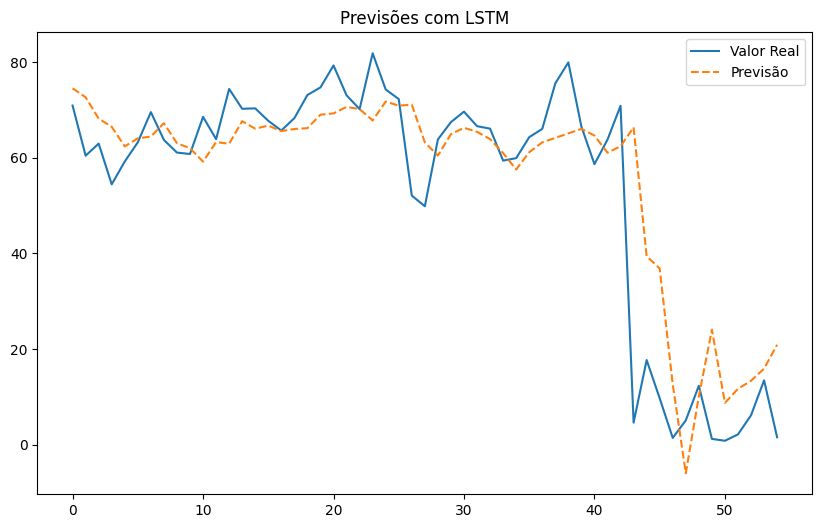

In [75]:
# Prevendo com o modelo
previsao = modelo.predict(X_teste)

aux_teste = np.zeros((len(previsao), serie_normalizada.shape[1]))
aux_teste[:, 0] = previsao[:, 0] 
serie_desnormalizada = scaler.inverse_transform(aux_teste)
previsao_desnormalizada = serie_desnormalizada[:, 0]

aux_real = np.zeros((len(y_teste), serie_desnormalizada.shape[1]))
aux_real[:, 0] = y_teste
y_real_desnormalizado = scaler.inverse_transform(aux_real)[:, 0]

# Visualizando as previsões
plt.figure(figsize=(10, 6))
plt.plot(y_real_desnormalizado, label='Valor Real')
plt.plot(previsao_desnormalizada, label='Previsão', linestyle='--')
plt.legend()
plt.title('Previsões com LSTM')
plt.show()

In [76]:
print("Previsto:", previsao_desnormalizada[:5])
print("Real:", y_real_desnormalizado[:5])

Previsto: [74.49430311 72.6246159  68.16788277 66.4436646  62.35414117]
Real: [70.88725846 60.41486553 62.93842599 54.43389098 59.1935443 ]


In [77]:
r2 = r2_score(y_real_desnormalizado, previsao_desnormalizada)
rmse = np.sqrt(mean_squared_error(y_real_desnormalizado, previsao_desnormalizada))
mae = mean_absolute_error(y_real_desnormalizado, previsao_desnormalizada)

print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

R²: 0.7694
RMSE: 12.4064
MAE: 7.7522


O resultado das métricas foram melhores em comparação com os do SARIMAX e do SARIMA, porém ficou claro no gráfico acima que as previsões do modelo apresentou diferenças consideraveis em relação aos valores reais. Os riscos de queimadas estão relacionados a diversos fatores externos que são pouco previsíveis (clima e ações humanas, por exemplo), principalmente em previsões de curto prazo. Todavia, a partir dos resultados acima e de outros estudos é possível identificar alguns padrões que possam ajudar na formulação de medidas preventivas.

# Referências

https://www.datageeks.com.br/lstm/

https://sigmoidal.ai/metricas-de-avaliacao-em-modelos-de-regressao-em-machine-learning/

https://ivanildo-batista13.medium.com/autoarima-em-python-26303d650de3

https://medium.com/ensina-ai/princ%C3%ADpios-b%C3%A1sicos-para-criar-previs%C3%B5es-de-s%C3%A9ries-temporais-e58c451a25b#:~:text=Toda%20s%C3%A9rie%20temporal%20pode%20ser,a%20s%C3%A9rie%20%C3%A9%20estatisticamente%20estacion%C3%A1ria.&text=Agora%20vamos%20analisar%20a%20s%C3%A9rie,para%20que%20ela%20fique%20estacion%C3%A1ria.

SETZER, Alberto Waingort; SISMANOGLU, Raffi Agop; DOS SANTOS, José Guilherme Martins. Método do Cálculo do Risco de Fogo do Programa do INPE-Versão 11, junho/2019. CEP, v. 12, n. 010, 2019.

https://www.linkedin.com/pulse/time-series-episode-3-arima-forecasting-exogenous-vasilis-kalyvas-c09kf/

https://zerotomastery.io/blog/arima-sarima-sarimax-explained/#SARIMAX-vs-SARIMA